In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import time

### Not important plotting helper function

In [2]:
def dynamic_plotting(samples):
    plt.ion()

    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 16
    fig_size[1] = 3

    fig1 = plt.figure(1)
    ax1_1 = fig1.add_subplot(121)
    fig1.canvas.draw()

    z= 100
    b = np.ones([1])

    for i in range(z):
        # update data 
        b = np.append(b, [samples[i*100:(i+1)*100]])
    
        # re-plot area 1 of fig1  
        ax1_1.clear()
        ax1_1.set_xlim (0, 10000)
        ax1_1.set_ylim (0, 1)
        ax1_1.plot(b)
    
        # redraw fig 1 
        fig1.canvas.draw()

# Define Probabilities

**Learn how the author deinfes probabilities in dictionaries for specific problem.**

In [3]:
prob_type = 0.25
prob_region = 0.55
prob_prod = {(1,1): 0.9, (1,0): 0.75, (0,1):0.8, (0,0):0.6}
prob_usage= {(1,): 0.5, (0,): 0.3}
prob_price = {(1,): 0.3, (0,): 0.6}
prob_cancel = {(1,1): 0.4, (1,0): 0.2, (0,1): 0.25, (0,0): 0.1}


# The last to lines are dictionary that enables building a computational graph
# In reject sampling, it is no used yet.
prob = {0: prob_type, 1: prob_region, 2: prob_prod, 3: prob_usage, 4: prob_price, 5: prob_cancel}
dep = {0: 'no', 1: 'no', 2: [0,1], 3: [2], 4: [3], 5: [3,4]}

# Reject Sampling

**Use Tuple as dictionary keys, you need to know:**                                       
https://docs.python.org/3/faq/design.html#why-are-there-separate-tuple-and-list-data-types

The hash table implementation of dictionaries uses a hash value calculated from the key value to find the key. If the key were a mutable object, its value could change, and thus its hash could also change. But since whoever changes the key object can’t tell that it was being used as a dictionary key, it can’t move the entry around in the dictionary. Then, when you try to look up the same object in the dictionary it won’t be found because its hash value is different. If you tried to look up the old value it wouldn’t be found either, because the value of the object found in that hash bin would be different.

If you want a dictionary indexed with a list, simply convert the list to a tuple first; the function tuple(L) creates a tuple with the same entries as the list L. Tuples are immutable and can therefore be used as dictionary keys.

In [4]:
samples = []
samples.append(0)

accept_count = 0
reject_count = 0

for i in range(10000):
    # 1 for hospital, 0 for Doctor's office
    t = np.random.choice([1,0], p = [prob_type, 1 - prob_type])
    
    # 1 for north, 0 for south
    r = np.random.choice([1,0], p = [prob_region, 1 - prob_region])
    
    # 1 for one product, 0 for two or more products
    p = np.random.choice([1,0], p = [prob_prod[(t,r)], 1 - prob_prod[(t,r)]])
    
    # 1 for low usage, 0 for high usage
    u = np.random.choice([1,0], p = [prob_usage[(p,)], 1 - prob_usage[(p,)]])
    
    # 1 for price increase, 0 for no price increase
    pr = np.random.choice([1,0], p = [prob_price[(u,)], 1 - prob_price[(u,)]])
    
    # 1 for cancel, 0 for not cancel
    c = np.random.choice([1,0], p = [prob_cancel[(u,pr)], 1 - prob_cancel[(u,pr)]])
    
    # since we want P(cancel |r = north)
    if r == 0:
        reject_count += 1
        
    else:
        avg = (samples[accept_count] * accept_count + c) / (accept_count + 1)
        samples.append(avg)
        accept_count += 1
        # here we don't store sampled values, we store our belief
        
        

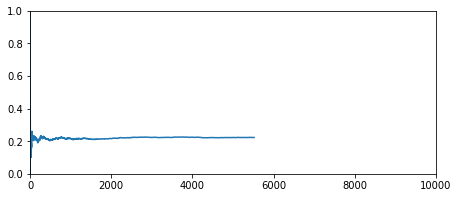

In [5]:
dynamic_plotting(samples)

In [6]:
print(samples[-1])

print("Proportion of samples rejected: {}".format(reject_count/10000))
print("Conditional probability with rejection sampling: {}".format(samples[9999-reject_count]))

0.22268526907048392
Proportion of samples rejected: 0.4481
Conditional probability with rejection sampling: 0.2225444001449802


### 知识点：Dynamic update Average, Probabilities within one piece of business code.

#### If we want to update mean                

Suppose we have a dictionary of means, each value is updated from its previous element.    
You update a value with previous mean and current value.     

now comes a new sample with value = `value`:            

Since we know             
```python
avg = sums / count
```

Now we update average `avg`              
```python
new_count = count + 1
new_sums = count* avg + value
new_avg = new_sums / new_count
new_avg = (count * avg) / (count + 1)
```

#### If we want to update a probability             

*Now we have a list of probabilities [values between 0 and 1]*    

Since we know
```python
prob = success / trials
```

Now comes a new value, that is either 0 or 1, 0 for failed, 1 for success.       

```python
new_success = trials *  prob +  value
new_trails = trials + 1
new_prob = (trials * prob) +  value / (trials + 1)
```

所以作者省去了存储一堆0和1， 只存储我当前的belief， 一段合格的工程代码。                  
当我们使用Epsilon Greddy 算法的时候，这个就特别有用了。                              

In [8]:
prob = {0: prob_type, 1: prob_region, 2: prob_prod, 3: prob_usage, 4: prob_price, 5: prob_cancel}
dep = {0: 'no', 1: 'no', 2: [0,1], 3: [2], 4: [3], 5: [3,4]}

In [7]:
# there are 6 vairables
variable = set(np.arange(6))

# the 2nd variable is the given variable
given = set([1])

# other variables are free
free_var = list(variable.difference(given))

# randomly pick a sample.
val = np.array([1,1,1,1,1,1])

In [ ]:
samples = list()

# append the 1st result from the 1st sample
samples.append(val[5])

for i in range(10000):
    
    # randomly choose a free variable
    var = np.random.choice(free_var)
    
    # if this variable has no parent variable
    # the variable can be drawn with its own probability distribution
    if dep[var]=='no':
        var_prob = prob[var]
        
    # if the variable has parent variable
    # find the current value of all the parent variables
    # find the probability of the current variable
    else:
        var_prob = prob[var][tuple(val[dep[var]])]
        
    # randomly draw a sample of the current variable
    rand = np.random.uniform()
    if rand <= var_prob:
        new_val = 1
    else:
        new_val = 0
    
    # set the value of current variable with new sampled value
    val[var] = new_val
    
    # now I have i samples, update probability
    avg = (samples[i]*i+val[5])/(i+1)
    samples.append(avg)